In [2]:
from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta
class MACDRSIStrategy(CtaTemplate):
    className = 'MACDRSIStrategy'
    author = 'Carey'
    # 策略参数
    ATRPeriod = 14; ATRlimit = 40    #经参数优化，非核心参数
    MA_jPeriod = 20; MD_jPeriod = 20  #经参数优化，非核心参数
    obvlonglimit = 0; obvshortlimit = -2 #经参数优化，核心参数
    stopRatio = 0.04
    lot = 1
    # 策略变量
    transactionPrice = {} # 记录成交价格
    volat = {}
    trend = {}
    # 参数列表，保存了参数的名称
    paramList = [
                 "ATRPeriod","ATRlimit"
                 "MA_jPeriod", "MD_jPeriod",
                 "obvlonglimit" , "obvshortlimit",
                 'stopRatio']                        ##参数列表不用写手数
    # 变量列表，保存了变量的名称
    varList = ['transactionPrice'
                  "volat"
                  "trend"]  
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']
    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        # 首先找到策略的父类（就是类CtaTemplate），然后把本策略对象转换为类CtaTemplate的对象
        super().__init__(ctaEngine, setting)
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList}
        self.volat = {s:0 for s in self.symbolList}
        self.trend = {s:0 for s in self.symbolList}
        self.putEvent()
    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送"""
        self.onBarStopLoss(bar)
    def onBarStopLoss(self, bar):
        symbol = bar.vtSymbol
        # 计算止损止盈价位
        longStop = self.transactionPrice[symbol]*(1-self.stopRatio)
        longProfit = self.transactionPrice[symbol]*(1+3*self.stopRatio)
        shortStop = self.transactionPrice[symbol]*(1+self.stopRatio)
        shortProfit = self.transactionPrice[symbol]*(1-3*self.stopRatio)
        # 洗价器
        if (self.posDict[symbol+'_LONG'] > 0):
            if (bar.close < longStop):
                print('LONG stopLoss')
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.posDict[symbol+'_LONG'])
            elif  (bar.close > longProfit):
                print('LONG takeProfit')
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.posDict[symbol+'_LONG'])
        elif (self.posDict[symbol+'_SHORT'] > 0):
            if (bar.close > shortStop):
                print('SHORT stopLoss')
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.posDict[symbol+'_SHORT'])
            elif (bar.close < shortProfit):
                print('SHORT takeProfit')
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.posDict[symbol+'_SHORT'])

    ####################################上涨趋势下跌单边趋势，添加布林带做反转，能量潮做过滤################################# 
    
    def on60MinBar(self, bar):
        symbol = bar.vtSymbol
        am60 = self.getArrayManager(symbol, "60m")
        if not am60.inited:
            return

        #atr14 = ta.ATR(am60.high,am60.low,am60.close,ATRPeriod)
        #if atr14[-1] > 40:
            #self.volat[symbol] = 1
        self.putEvent()
    def on30MinBar(self, bar):
        symbol = bar.vtSymbol
        am30 = self.getArrayManager(symbol, "30m")
        if not am30.inited:
            return
        atr14 = ta.ATR(am30.high,am30.low,am30.close,self.ATRPeriod)   #当市场波动率大时，有益于反转策略进出场
        if atr14[-1] > self.ATRlimit:                                                      
            self.volat[symbol] = 1
        
        #中间周期换成布林带反转
        MA_j = ta.MA(am30.close,self.MA_jPeriod)
        MD_j = ta.STDDEV(am30.close,self.MD_jPeriod)
        Bolldown_j = MA_j - 2*MD_j
        Bollup_j = MA_j + 2*MD_j
        
        #sigma = (am30.close[-1] - Bolldown_j[-1]) / (Bollup_j[-1] - Bolldown_j[-1])
        #sigma_width = (Bollup_j[-1] - MA_j[-1]) / (2*MA_j[-1])
        
        #Boll_long = (am30.close[-2] > Bolldown_j[-2]) and (am30.close[-1] <= Bolldown_j[-1]) and (am30.close[-1] >= Bollup_j[-1])#and (sigma <= 0)
        #Boll_short = (am30.close[-2] < Bollup_j[-2]) and (am30.close[-1] >= Bollup_j[-1]) and (am30.high[-1] >= Bollup_j[-1])#and (sigma > 1) 
        Boll_long = (am30.close[-1] > Bolldown_j[-1]) and (am30.low[-1] <= Bolldown_j[-1])
        Boll_short = (am30.close[-1] < Bollup_j[-1]) and (am30.high[-1] >= Bollup_j[-1]) 

        #成交量做过滤
        obv = ta.OBV(am30.close,ta.LOG10(am30.volume))  #成交量太大，对其取对数，降低成交量变动数值大小
        #obv_long = (obv[-2]<0) and (obv[-1]>0)  #买入
        #obv_short = (obv[-2]>0) and (obv[-1]<0)  #卖出
        obv_long = obv[-1]>self.obvlonglimit #买入
        obv_short = obv[-1]<self.obvshortlimit  #卖出
        
        
        # 趋势为多头
        if (Boll_long and obv_long) and (self.volat[symbol]==1) and (self.posDict[symbol+'_LONG']==0):  
            if  (self.posDict[symbol+'_SHORT']==0):  #没有持仓
                self.buy(symbol, bar.close*1.01, self.lot)  # 成交价*1.01发送高价位的限价单，以最优市价买入进场
            elif (self.posDict[symbol+'_SHORT'] > 0):
                self.cancelAll() # 撤销挂单
                self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
                self.buy(symbol, bar.close*1.01, self.lot)
        # 趋势为空头
        if (Boll_short and obv_short) and (self.volat[symbol]==1) and (self.posDict[symbol+'_SHORT']==0): 
            if (self.posDict[symbol+'_LONG']==0):
                self.short(symbol, bar.close*0.99, self.lot) # 成交价*0.99发送低价位的限价单，以最优市价卖出进场
            elif (self.posDict[symbol+'_LONG'] > 0):
                self.cancelAll() # 撤销挂单
                self.sell(symbol, bar.close*0.99, self.posDict[symbol+'_LONG'])
                self.short(symbol, bar.close*0.99, self.lot)

                
        # 发出状态更新事件
        self.putEvent()
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
#             print(trade.tradeTime, self.posDict)
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [3]:
from vnpy.trader.app.ctaStrategy import BacktestingEngine
# 创建回测引擎对象
engine = BacktestingEngine()
# 设置回测使用的数据
engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
engine.setDatabase('VnTrader_1Min_Db')  # 设置使用的历史数据库
engine.setStartDate('20180601 12:00',initHours=200) # 设置回测用的数据起始日期
engine.setEndDate('20181201 12:00') # 设置回测用的数据终止日期
# 配置回测引擎参数
engine.setSlippage(0.002)    # 设置滑点
engine.setRate(5/10000)   # 设置手续费千1
engine.setCapital(100000)  # 设置回测本金

In [4]:
# 在引擎中创建策略对象
parameterDict = {'symbolList':['BTCUSDT:binance']} # 策略参数配置
engine.initStrategy(MACDRSIStrategy, parameterDict)    # 创建策略对象
engine.runBacktesting()

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MACDRSIStrategy.on60MinBar at 0x1a1c43a950>, <__main__.MACDRSIStrategy object at 0x1068efcf8>)
[DEBUG] 注册品种BTCUSDT:binance上的on_30Min_bar函数functools.partial(<function MACDRSIStrategy.on30MinBar at 0x1a1c43a840>, <__main__.MACDRSIStrategy object at 0x1068efcf8>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MACDRSIStrategy.onBar at 0x1a1c43a8c8>, <__main__.MACDRSIStrategy object at 0x1068efcf8>)
2018-12-15 17:08:03.942876	开始回测
2018-12-15 17:08:03.942908	策略初始化
2018-12-15 17:08:03.943703	载入历史数据。数据范围:[20180524 04:00,20180601 12:00)
2018-12-15 17:08:05.072081	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-15 17:08:05.074650	载入完成，数据量：12000
2018-12-15 17:08:05.074791	策略初始化完成
2018-12-15 17:08:05.074815	策略启动完成
2018-12-15 17:08:05.074857	开始回放回测数据,回测范围:[20180601 12:00,20181201 12:00)
2018-12-15 17:08:05.091327	载入历史数据。数据范围:[20180601 12:00,

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

In [5]:
import pandas as pd
tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
tradeDf = tradeReport.set_index('dt')
tradeDf.tail()

,direction,exchange,exchangeOrderID,fee,gatewayName,offset,orderID,orderTime,price,price_avg,rawData,status,symbol,tradeID,tradeTime,volume,vtOrderID,vtSymbol,vtTradeID
dt,,,,,,,,,,,,,,,,,,,
2018-11-27 17:30:00,多,,,0.0,,开仓,173,,3770.36,0.0,None,,,173,2018-11-27 17:30:00,1,173,BTCUSDT:binance,173
2018-11-28 22:24:00,空,,,0.0,,平仓,174,,4229.73,0.0,None,,,174,2018-11-28 22:24:00,1,174,BTCUSDT:binance,174
2018-11-29 10:00:00,多,,,0.0,,开仓,175,,4164.07,0.0,None,,,175,2018-11-29 10:00:00,1,175,BTCUSDT:binance,175
2018-11-30 20:34:00,空,,,0.0,,平仓,176,,3966.65,0.0,None,,,176,2018-11-30 20:34:00,1,176,BTCUSDT:binance,176
2018-11-30 21:00:00,多,,,0.0,,开仓,177,,4025.79,0.0,None,,,177,2018-11-30 21:00:00,1,177,BTCUSDT:binance,177


2018-12-15 17:08:55.615943	计算按日统计结果
2018-12-15 17:08:55.647756	------------------------------
2018-12-15 17:08:55.647884	首个交易日：	2018-06-01 00:00:00
2018-12-15 17:08:55.647921	最后交易日：	2018-12-01 00:00:00
2018-12-15 17:08:55.647949	总交易日：	184
2018-12-15 17:08:55.647977	盈利交易日	107
2018-12-15 17:08:55.648004	亏损交易日：	75
2018-12-15 17:08:55.648033	起始资金：	100000
2018-12-15 17:08:55.648477	结束资金：	104,924.37
2018-12-15 17:08:55.648544	总收益率：	4.92%
2018-12-15 17:08:55.648586	年化收益：	6.42%
2018-12-15 17:08:55.648624	总盈亏：	4,924.37
2018-12-15 17:08:55.648666	最大回撤: 	-2,340.91
2018-12-15 17:08:55.648702	百分比最大回撤: -2.32%
2018-12-15 17:08:55.648740	总手续费：	576.44
2018-12-15 17:08:55.648776	总滑点：	0.35
2018-12-15 17:08:55.648811	总成交金额：	1,152,887.67
2018-12-15 17:08:55.648843	总成交笔数：	177
2018-12-15 17:08:55.648878	日均盈亏：	26.76
2018-12-15 17:08:55.648912	日均手续费：	3.13
2018-12-15 17:08:55.648947	日均滑点：	0.0
2018-12-15 17:08:55.648983	日均成交金额：	6,265.69
2018-12-15 17:08:55.649018	日均成交笔数：	0.96
2018-12-15 17:08:55.649047	日均收益率：	0.

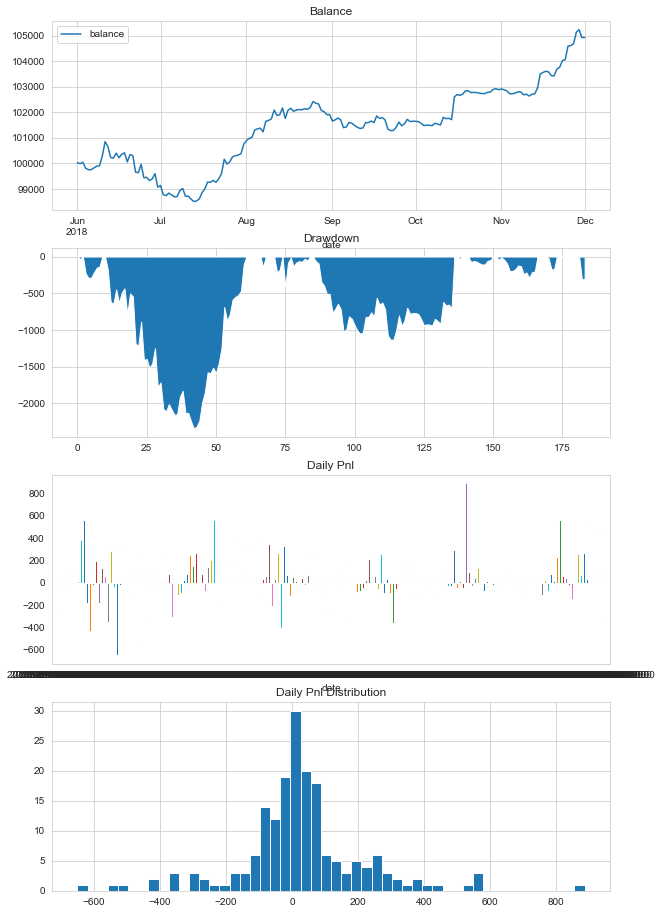

In [6]:
# 显示逐日回测结果
engine.showDailyResult()

2018-12-15 17:09:13.698392	计算回测结果
2018-12-15 17:09:13.705348	------------------------------
2018-12-15 17:09:13.705441	第一笔交易：	2018-06-02 08:00:00
2018-12-15 17:09:13.705471	最后一笔交易：	2018-12-01 11:58:00
2018-12-15 17:09:13.705502	总交易次数：	89
2018-12-15 17:09:13.705533	总盈亏：	4,922.36
2018-12-15 17:09:13.705562	最大回撤: 	-2,251.28
2018-12-15 17:09:13.705590	平均每笔盈利：	55.31
2018-12-15 17:09:13.705616	平均每笔滑点：	0.0
2018-12-15 17:09:13.705642	平均每笔佣金：	6.5
2018-12-15 17:09:13.705668	胜率		46.07%
2018-12-15 17:09:13.705694	盈利交易平均值	275.94
2018-12-15 17:09:13.705719	亏损交易平均值	-133.15
2018-12-15 17:09:13.705745	盈亏比：	2.07


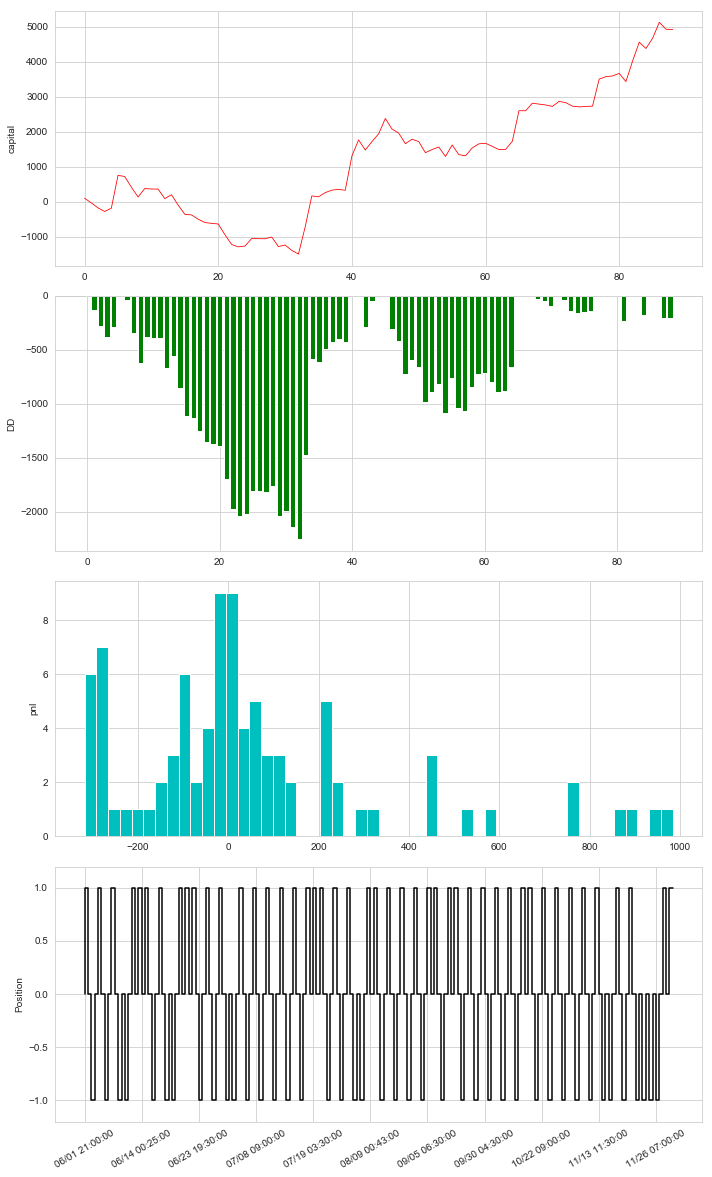

In [7]:
# 显示逐笔回测结果
engine.showBacktestingResult()

In [8]:
df = engine.calculateDailyResult()
df1, result = engine.calculateDailyStatistics(df)

2018-12-15 17:09:19.174874	计算按日统计结果


In [9]:
print(pd.Series(result)) # 显示绩效指标

startDate           2018-06-01 00:00:00
endDate             2018-12-01 00:00:00
totalDays                           184
profitDays                          107
lossDays                             75
endBalance                       104924
maxDrawdown                    -2340.91
maxDdPercent                   -2.32125
totalNetPnl                     4924.37
dailyNetPnl                     26.7629
totalCommission                 576.444
dailyCommission                 3.13285
totalSlippage                     0.354
dailySlippage                0.00192391
totalTurnover               1.15289e+06
dailyTurnover                   6265.69
totalTradeCount                     177
dailyTradeCount                0.961957
totalReturn                     4.92437
annualizedReturn                6.42309
dailyReturn                   0.0259857
returnStd                      0.191791
sharpeRatio                     2.09899
dtype: object


In [ ]:
####参数优化

In [5]:
from vnpy.trader.app.ctaStrategy.ctaBacktesting  import OptimizationSetting
# 优化配置
setting = OptimizationSetting()                # 新建一个优化任务设置对象
setting.setOptimizeTarget('sharpeRatio')        # 设置优化排序的目标是夏普
setting.addParameter("obvlonglimit", 0, 10, 2)    # 增加第一个优化参数，起始30，结束50，步进10
setting.addParameter("obvshortlimit", -10, 0, 2)    # 增加第二个优化参数，起始60，结束30，步进10
# setting.addParameter('signalMaPeriod', 10, 20, 5)    # 增加第二个优化参数，起始10，结束30，步进5
setting.addParameter('symbolList', ['BTCUSDT:binance']) 
import time
start = time.time()
# 执行单线程优化
resultList = engine.runOptimization(MACDRSIStrategy, setting)
print('耗时：%s' %(time.time()-start))

2018-12-15 14:02:08.339749	------------------------------
2018-12-15 14:02:08.339878	setting: {'obvlonglimit': 0, 'obvshortlimit': -10, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MACDRSIStrategy.on60MinBar at 0x1a1f183d08>, <__main__.MACDRSIStrategy object at 0x1a1f1872e8>)
[DEBUG] 注册品种BTCUSDT:binance上的on_30Min_bar函数functools.partial(<function MACDRSIStrategy.on30MinBar at 0x1a1f183bf8>, <__main__.MACDRSIStrategy object at 0x1a1f1872e8>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MACDRSIStrategy.onBar at 0x1a1f183c80>, <__main__.MACDRSIStrategy object at 0x1a1f1872e8>)
2018-12-15 14:02:08.340256	开始回测
2018-12-15 14:02:08.340286	策略初始化
2018-12-15 14:02:08.341193	载入历史数据。数据范围:[20180524 04:00,20180601 12:00)
2018-12-15 14:02:39.868428	失去MongoDB的连接，我们尝试使用本地缓存数据，请注意数据量
2018-12-15 14:02:39.877868	载入完成，数据量：12000
2018-12-15 14:02:39.878020

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 271, in loadHistoryData
    if symbol in self.dbClient[self.dbName].collection_names():
  File "/anaconda3/lib/python3.6/site-packages/pymongo/database.py", line 715, in collection_names
    nameOnly=True, **kws)]
  File "/anaconda3/lib/python3.6/site-packages/pymongo/database.py", line 674, in list_collections
    read_pref) as (sock_info, slave_okay):
  File "/anaconda3/lib/python3.6/contextlib.py", line 81, in __enter__
    return next(self.gen)
  File "/anaconda3/lib/python3.6/site-packages/pymongo/mongo_client.py", line 1099, in _socket_for_reads
    server = topology.select_server(read_preference)
  File "/anaconda3/lib/python3.6/site-packages/pymongo/topology.py", line 224, in select_server
    address))
  File "/anaconda3/lib/python3.6/site-packages/pymongo/topology.py", line 183, in select_servers
    selector, serv

2018-12-15 14:03:23.612710	失去MongoDB的连接，我们尝试使用本地缓存数据，请注意数据量
2018-12-15 14:03:23.683574	载入完成，数据量：261728
2018-12-15 14:03:23.683806	当前回放数据:[20180601 12:00,20181201 12:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180601120000
2018-12-15 14:03:23.684865	载入历史数据。数据范围:[20180531 20:51,20180603 12:01)


Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 271, in loadHistoryData
    if symbol in self.dbClient[self.dbName].collection_names():
  File "/anaconda3/lib/python3.6/site-packages/pymongo/database.py", line 715, in collection_names
    nameOnly=True, **kws)]
  File "/anaconda3/lib/python3.6/site-packages/pymongo/database.py", line 674, in list_collections
    read_pref) as (sock_info, slave_okay):
  File "/anaconda3/lib/python3.6/contextlib.py", line 81, in __enter__
    return next(self.gen)
  File "/anaconda3/lib/python3.6/site-packages/pymongo/mongo_client.py", line 1099, in _socket_for_reads
    server = topology.select_server(read_preference)
  File "/anaconda3/lib/python3.6/site-packages/pymongo/topology.py", line 224, in select_server
    address))
  File "/anaconda3/lib/python3.6/site-packages/pymongo/topology.py", line 183, in select_servers
    selector, serv

2018-12-15 14:03:54.171958	失去MongoDB的连接，我们尝试使用本地缓存数据，请注意数据量
2018-12-15 14:03:54.175733	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180601102100 , 20180601120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180601120000
[INFO] 品种BTCUSDT:binance开始生成未完成的60mK线数据,时间起点为:20180601120000
2018-12-15 14:03:54.202734	载入历史数据。数据范围:[20180424 15:00,20180531 20:50)


Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 271, in loadHistoryData
    if symbol in self.dbClient[self.dbName].collection_names():
  File "/anaconda3/lib/python3.6/site-packages/pymongo/database.py", line 715, in collection_names
    nameOnly=True, **kws)]
  File "/anaconda3/lib/python3.6/site-packages/pymongo/database.py", line 674, in list_collections
    read_pref) as (sock_info, slave_okay):
  File "/anaconda3/lib/python3.6/contextlib.py", line 81, in __enter__
    return next(self.gen)
  File "/anaconda3/lib/python3.6/site-packages/pymongo/mongo_client.py", line 1099, in _socket_for_reads
    server = topology.select_server(read_preference)
  File "/anaconda3/lib/python3.6/site-packages/pymongo/topology.py", line 224, in select_server
    address))
  File "/anaconda3/lib/python3.6/site-packages/pymongo/topology.py", line 183, in select_servers
    selector, serv

2018-12-15 14:04:19.784322	失去MongoDB的连接，我们尝试使用本地缓存数据，请注意数据量
2018-12-15 14:04:19.798009	载入完成，数据量：44450
2018-12-15 14:04:19.803464	载入历史数据。数据范围:[20180603 12:01,20180603 13:00)
2018-12-15 14:04:19.807152	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-15 14:04:19.807222	！！ 数据量为 0 ！！


Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

In [7]:
# 显示优化的所有统计数据
for result in resultList:
    print('-' * 30)
    print('参数：%s，目标：%s' %(result[0], result[1]))
    print('统计数据：')
    for k, v in result[2].items():
        print('%s：%s' %(k, v))

------------------------------
参数：["{'obvlonglimit': 0, 'obvshortlimit': -4, 'symbolList': ['BTCUSDT:binance']}"]，目标：2.1382901520288002
统计数据：
startDate：2018-06-01 00:00:00
endDate：2018-12-01 00:00:00
totalDays：184
profitDays：107
lossDays：74
endBalance：105004.92642
maxDrawdown：-2270.7920550000126
maxDdPercent：-2.2515277791083914
totalNetPnl：5004.926420000002
dailyNetPnl：27.2006870652174
totalCommission：538.26358
dailyCommission：2.925345543478261
totalSlippage：0.33000000000000007
dailySlippage：0.0017934782608695656
totalTurnover：1076527.16
dailyTurnover：5850.691086956521
totalTradeCount：165
dailyTradeCount：0.8967391304347826
totalReturn：5.004926420000011
annualizedReturn：6.528164895652188
dailyReturn：0.026402784817598116
returnStd：0.19128843818512475
sharpeRatio：2.1382901520288002
------------------------------
参数：["{'obvlonglimit': 0, 'obvshortlimit': -6, 'symbolList': ['BTCUSDT:binance']}"]，目标：2.1350001463771564
统计数据：
startDate：2018-06-01 00:00:00
endDate：2018-12-01 00:00:00
totalDays：

In [8]:
from vnpy.trader.app.ctaStrategy.ctaBacktesting  import OptimizationSetting
# 优化配置
setting = OptimizationSetting()                # 新建一个优化任务设置对象
setting.setOptimizeTarget('sharpeRatio')        # 设置优化排序的目标是夏普
setting.addParameter("MA_jPeriod", 10, 80, 5)    # 增加第一个优化参数，起始30，结束50，步进10
setting.addParameter("MD_jPeriod", 10, 80, 5)    # 增加第二个优化参数，起始60，结束30，步进10
# setting.addParameter('signalMaPeriod', 10, 20, 5)    # 增加第二个优化参数，起始10，结束30，步进5
setting.addParameter('symbolList', ['BTCUSDT:binance']) 
import time
start = time.time()
# 执行单线程优化
resultList = engine.runOptimization(MACDRSIStrategy, setting)
print('耗时：%s' %(time.time()-start))

2018-12-15 14:41:58.433665	------------------------------
2018-12-15 14:41:58.433925	setting: {'MA_jPeriod': 10, 'MD_jPeriod': 10, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MACDRSIStrategy.on60MinBar at 0x1a2e02b0d0>, <__main__.MACDRSIStrategy object at 0x1a2e0abf98>)
[DEBUG] 注册品种BTCUSDT:binance上的on_30Min_bar函数functools.partial(<function MACDRSIStrategy.on30MinBar at 0x108af4bf8>, <__main__.MACDRSIStrategy object at 0x1a2e0abf98>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MACDRSIStrategy.onBar at 0x108af4d90>, <__main__.MACDRSIStrategy object at 0x1a2e0abf98>)
2018-12-15 14:41:58.454311	开始回测
2018-12-15 14:41:58.454355	策略初始化
2018-12-15 14:41:58.455136	载入历史数据。数据范围:[20180524 04:00,20180601 12:00)
2018-12-15 14:41:58.998812	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-15 14:41:59.002393	载入完成，数据量：12000
2018-12-15 14:41:59.002586	策略初

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530100000 , 20180601113000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成30mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7484.97, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 500.195963, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史30mK线更新，范围为:[20180530103000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的30mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

In [9]:
import pandas as pd
print(pd.DataFrame(resultList).sort_values(1,  ascending=False))

                                                     0         1  \
0    [{'MA_jPeriod': 10, 'MD_jPeriod': 20, 'symbolL...  2.099239   
8    [{'MA_jPeriod': 50, 'MD_jPeriod': 20, 'symbolL...  2.099239   
1    [{'MA_jPeriod': 15, 'MD_jPeriod': 20, 'symbolL...  2.099239   
14   [{'MA_jPeriod': 80, 'MD_jPeriod': 20, 'symbolL...  2.099239   
13   [{'MA_jPeriod': 75, 'MD_jPeriod': 20, 'symbolL...  2.099239   
12   [{'MA_jPeriod': 70, 'MD_jPeriod': 20, 'symbolL...  2.099239   
10   [{'MA_jPeriod': 60, 'MD_jPeriod': 20, 'symbolL...  2.099239   
9    [{'MA_jPeriod': 55, 'MD_jPeriod': 20, 'symbolL...  2.099239   
11   [{'MA_jPeriod': 65, 'MD_jPeriod': 20, 'symbolL...  2.099239   
7    [{'MA_jPeriod': 45, 'MD_jPeriod': 20, 'symbolL...  2.099239   
6    [{'MA_jPeriod': 40, 'MD_jPeriod': 20, 'symbolL...  2.099239   
5    [{'MA_jPeriod': 35, 'MD_jPeriod': 20, 'symbolL...  2.099239   
4    [{'MA_jPeriod': 30, 'MD_jPeriod': 20, 'symbolL...  2.099239   
3    [{'MA_jPeriod': 25, 'MD_jPeriod': 20, 'symb